In [35]:
import os
import numpy as np
import tempfile
import pickle
from functools import partial

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import lightning.pytorch as pl


import lightning_uq_box as luq

<h2> Load OCO-2 Soundings </h2>

In [65]:
# load the example pickle file
pkl_str = "/Users/williamkeely/Desktop/Fast_Retrieval/Data/L2DiaND_XCO2_2020_downsampled_eof_removed_aligned.p"
data = pickle.load(open(pkl_str, "rb"))

# print the keys of the pickle file
print(data.keys())

# print the shape of the sco2_band
print(len(data["sco2_band"]))

dict_keys(['o2_band', 'wco2_band', 'sco2_band', 'o2_band_no_eof', 'wco2_band_no_eof', 'sco2_band_no_eof', 'o2_band_obs', 'wco2_band_obs', 'sco2_band_obs', 'o2_band_idxs', 'wco2_band_idxs', 'sco2_band_idxs', 'o2_wl', 'wco2_wl', 'sco2_wl', 'num_color', 'states', 'state_var'])
4317


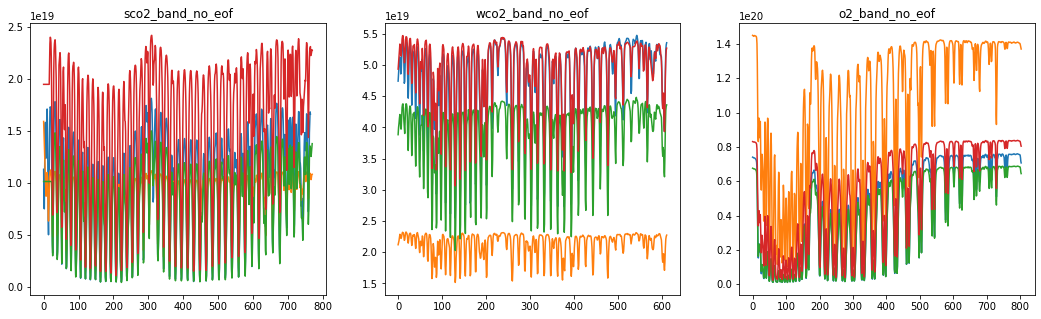

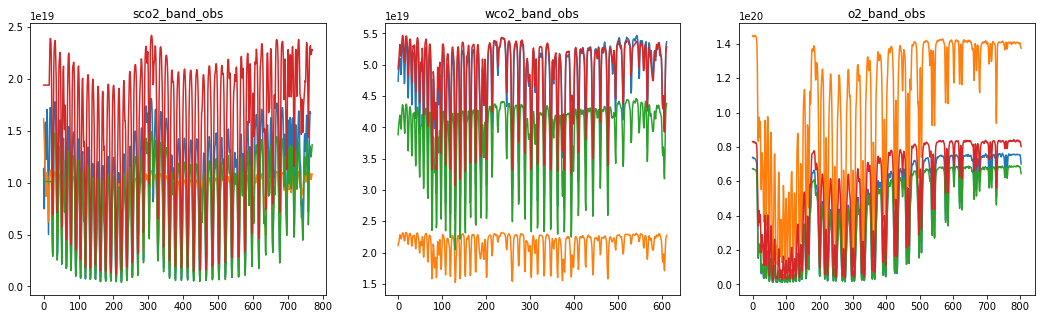

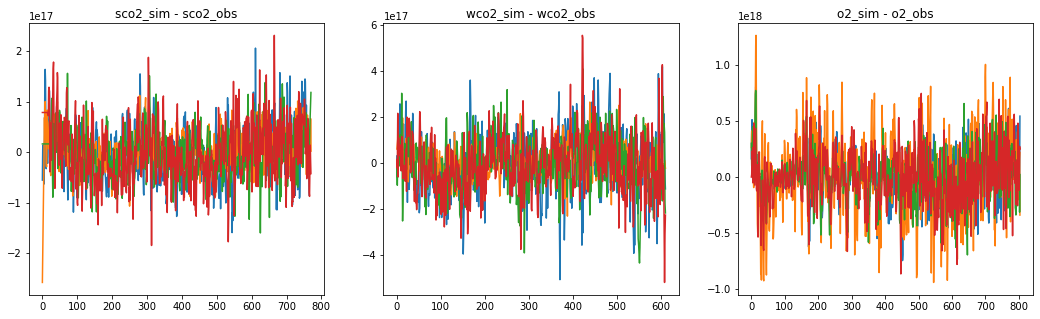

In [20]:
# vizualize the radiances with EOF removed
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
ax[0].plot(data["sco2_band_no_eof"][0])
ax[0].plot(data["sco2_band_no_eof"][1000])
ax[0].plot(data["sco2_band_no_eof"][2000])
ax[0].plot(data["sco2_band_no_eof"][4000])
ax[0].set_title("sco2_band_no_eof")

ax[1].plot(data["wco2_band_no_eof"][0])
ax[1].plot(data["wco2_band_no_eof"][1000])
ax[1].plot(data["wco2_band_no_eof"][2000])
ax[1].plot(data["wco2_band_no_eof"][4000])
ax[1].set_title("wco2_band_no_eof")

ax[2].plot(data["o2_band_no_eof"][0])
ax[2].plot(data["o2_band_no_eof"][1000])
ax[2].plot(data["o2_band_no_eof"][2000])
ax[2].plot(data["o2_band_no_eof"][4000])
ax[2].set_title("o2_band_no_eof")

plt.show()

# vizualize the observations
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
ax[0].plot(data["sco2_band_obs"][0])
ax[0].plot(data["sco2_band_obs"][1000])
ax[0].plot(data["sco2_band_obs"][2000])
ax[0].plot(data["sco2_band_obs"][4000])
ax[0].set_title("sco2_band_obs")

ax[1].plot(data["wco2_band_obs"][0])
ax[1].plot(data["wco2_band_obs"][1000])
ax[1].plot(data["wco2_band_obs"][2000])
ax[1].plot(data["wco2_band_obs"][4000])
ax[1].set_title("wco2_band_obs")

ax[2].plot(data["o2_band_obs"][0])
ax[2].plot(data["o2_band_obs"][1000])
ax[2].plot(data["o2_band_obs"][2000])
ax[2].plot(data["o2_band_obs"][4000])
ax[2].set_title("o2_band_obs")

plt.show()

# vizualize the difference
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
ax[0].plot(data["sco2_band_no_eof"][0] - data["sco2_band_obs"][0])
ax[0].plot(data["sco2_band_no_eof"][1000] - data["sco2_band_obs"][1000])
ax[0].plot(data["sco2_band_no_eof"][2000] - data["sco2_band_obs"][2000])
ax[0].plot(data["sco2_band_no_eof"][4000] - data["sco2_band_obs"][4000])
ax[0].set_title("sco2_sim - sco2_obs")

ax[1].plot(data["wco2_band_no_eof"][0] - data["wco2_band_obs"][0])
ax[1].plot(data["wco2_band_no_eof"][1000] - data["wco2_band_obs"][1000])
ax[1].plot(data["wco2_band_no_eof"][2000] - data["wco2_band_obs"][2000])
ax[1].plot(data["wco2_band_no_eof"][4000] - data["wco2_band_obs"][4000])
ax[1].set_title("wco2_sim - wco2_obs")

ax[2].plot(data["o2_band_no_eof"][0] - data["o2_band_obs"][0])
ax[2].plot(data["o2_band_no_eof"][1000] - data["o2_band_obs"][1000])
ax[2].plot(data["o2_band_no_eof"][2000] - data["o2_band_obs"][2000])
ax[2].plot(data["o2_band_no_eof"][4000] - data["o2_band_obs"][4000])
ax[2].set_title("o2_sim - o2_obs")

plt.show()




<h2>Lightning Data Loader </h2>

In [77]:
# define the Lightning DataSet for Xgas retrieval
from torch.utils.data import Dataset
class RetrievalDataSet(Dataset):
    '''OCO-2 DataSet for Xgas retrieval'''
    def __init__(self, train_files, test_files, train=True, normalize=True, transform=None, normalize_file='normalize.pkl'):
        """
        Args:
            train_files (list): List of file paths to be used for training.
            test_files (list): List of file paths to be used for testing.
            train (bool): If True, use train_files else use test_files.
            normalize (bool) : If True, normalize the data.
            transform (callable, optional): Optional transform to be applied on a sample.
            normalize_file (str): Path to the normalization file.
        """
        self.train_files = train_files
        self.test_files = test_files
        self.train = train
        self.normalize = normalize
        self.transform = transform
        self.normalize_file = normalize_file
        
        # Load data based on the file paths
        self.data, self.targets = self.load_data()
        


    def load_data(self):
        # TODO : obs will need to be replaced by the adjusted sim diff adusted obs in the future [...]
        data = {'sco2': [], 'wco2': [], 'o2': []}
        targets = []
        
        files = self.train_files if self.train else self.test_files
        for file_path in files:
            try:
                with open(file_path, 'rb') as file:
                    file_data = pickle.load(file)
                    
                    if self.train:
                        data['sco2'].extend(file_data['sco2_band_no_eof'])
                        data['wco2'].extend(file_data['wco2_band_no_eof'])
                        data['o2'].extend(file_data['o2_band_no_eof'])
                    else:
                        data['sco2'].extend(file_data['sco2_band_obs'])
                        data['wco2'].extend(file_data['wco2_band_obs'])
                        data['o2'].extend(file_data['o2_band_obs'])
                    # get the idx in state where state_name is 'RetrievalResults/xco2'
                    xco2_idx = file_data['state_var'].index('RetrievalResults/xco2')
                    xco2_values = [state[xco2_idx] for state in file_data['states']]
                    targets.extend(xco2_values)
                    print(targets[:10])
            except (FileNotFoundError, KeyError, pickle.UnpicklingError) as e:
                print(f"Error loading file {file_path}: {e}")
            
            # normalize the data
            if not self.train:
                if self.normalize:
                    # load the normalization parameters from pickle
                    with open(self.normalize_file, 'rb') as file:
                        norm_params = pickle.load(file)
                        sco2_mean = norm_params['sco2_mean']
                        sco2_std = norm_params['sco2_std']
                        wco2_mean = norm_params['wco2_mean']
                        wco2_std = norm_params['wco2_std']
                        o2_mean = norm_params['o2_mean']
                        o2_std = norm_params['o2_std']
                        targets_mean = norm_params['targets_mean']
                        targets_std = norm_params['targets_std']
                        data['sco2'] = (data['sco2'] - sco2_mean) / sco2_std
                        data['wco2'] = (data['wco2'] - wco2_mean) / wco2_std
                        data['o2'] = (data['o2'] - o2_mean) / o2_std
                        targets = (targets - targets_mean) / targets_std
                    

                    
            else:
                if self.normalize:
                    sco2_mean = np.nanmean(data['sco2'])
                    sco2_std = np.nanstd(data['sco2'])
                    wco2_mean = np.nanmean(data['wco2'])
                    wco2_std = np.nanstd(data['wco2'])
                    o2_mean = np.nanmean(data['o2'])
                    o2_std = np.nanstd(data['o2'])
                    targets_mean = np.nanmean(targets)
                    targets_std = np.nanstd(targets)
                    data['sco2'] = (data['sco2'] - sco2_mean) / sco2_std
                    data['wco2'] = (data['wco2'] - wco2_mean) / wco2_std
                    data['o2'] = (data['o2'] - o2_mean) / o2_std
                    targets = (targets - targets_mean) / targets_std
                    # save the normalization parameters to pickle
                    curr_dir = '/Users/williamkeely/Desktop/Fast_Retrieval/Data/'
                    self.normalize_file = os.path.join(curr_dir, self.normalize_file)
                    with open(self.normalize_file, 'wb') as file:
                        pickle.dump({'sco2_mean': sco2_mean, 'sco2_std': sco2_std,
                                     'wco2_mean': wco2_mean, 'wco2_std': wco2_std,
                                     'o2_mean': o2_mean, 'o2_std': o2_std,
                                     'targets_mean': targets_mean, 'targets_std': targets_std}, file)
        # Ensure all lists have the same length
        sco2_length = len(data['sco2'])
        wco2_length = len(data['wco2'])
        o2_length = len(data['o2'])
        targets_length = len(targets)
        print(f"sco2 length: {sco2_length}, wco2 length: {wco2_length}, o2 length: {o2_length}, targets length: {targets_length}")
        
        # Ensure all lists have the same length
        assert sco2_length == wco2_length == o2_length == targets_length, "Data lengths do not match"
        return data, targets


    def __len__(self) -> int:
        return len(self.targets)

    def __getitem__(self, idx) -> Tensor:
        X_sco2 = self.data['sco2'][idx]
        X_wco2 =  self.data['wco2'][idx]
        X_o2 = self.data['o2'][idx]
        # X_train = np.concatenate((X_sco2, X_wco2, X_o2), axis=0)
        sample = {
            'X_sco2' : X_sco2,
            'X_wco2' : X_wco2,
            'X_o2' : X_o2,
            'y': self.targets[idx]
        }
        if self.transform:
            sample = self.transform(sample)
        return sample

class ToyDonut(Dataset):
    """Toy Donut for Regression."""

    def __init__(
        self,
        inner_radius: float = 8.0,
        outer_radius: float = 10.0,
        n_samples: int = 1000,
        noise=0.1,
    ):
        """Initialize a new instance of the dataset.

        Args:
            inner_radius: The inner radius of the donut.
            outer_radius: The outer radius of the donut.
            n_samples: The total number of samples in the dataset.
            noise: The amount of noise to add to the data.
        """
        self.inner_radius = inner_radius
        self.outer_radius = outer_radius
        self.n_samples = n_samples
        self.noise = noise

        # Generate uniform random angles
        self.theta = 2 * np.pi * torch.rand(n_samples)

        # Generate uniform random radii within the donut
        self.radii = (
            torch.rand(n_samples) * (outer_radius - inner_radius) + inner_radius
        )

        # Generate the x and y values
        self.X = (self.radii + self.noise * torch.randn(n_samples)).float() * torch.cos(
            self.theta
        )
        self.X = self.X.unsqueeze(-1)
        self.y = (self.radii + self.noise * torch.randn(n_samples)).float() * torch.sin(
            self.theta
        )
        self.y = self.y.unsqueeze(-1)

    def __len__(self) -> int:
        """Return the length of the dataset."""
        return self.n_samples

    def __getitem__(self, idx) -> dict[str, Tensor]:
        """Return a sample from the dataset.

        Args:
            idx: The index of the sample to return.

        Returns:
            A dictionary containing the input and target values.
        """
        return {"input": self.X[idx], "target": self.y[idx]}



# test that it works with the pkl_str from above. Set train_files and test_files to the same pkl_str
train_files = [pkl_str]
test_files = [pkl_str]
dataset = RetrievalDataSet(train_files, test_files, train=True, transform=None, normalize_file='normalize.pkl')
print(len(dataset))

# test the ToyDonut dataset
dataset_Donut = ToyDonut()
print(len(dataset_Donut))








[0.00041184178553521633, 0.0004096207849215716, 0.00041057588532567024, 0.00041097242501564324, 0.00041043321834877133, 0.0004086130065843463, 0.0004111034795641899, 0.00041248102206736803, 0.0004113397153560072, 0.0004162303521297872]
sco2 length: 4317, wco2 length: 4317, o2 length: 4317, targets length: 4317
4317
1000


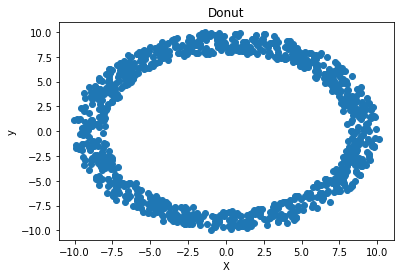

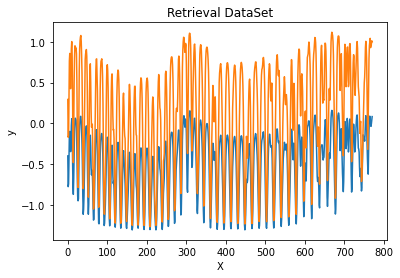

In [78]:
# plot the Donut
fig, ax = plt.subplots()
ax.scatter(dataset_Donut.X, dataset_Donut.y)
ax.set_xlabel("X")
ax.set_ylabel("y")
ax.set_title("Donut")
plt.show()

# plot the X from the retrieval dataset
fig, ax = plt.subplots()
ax.plot(dataset[4001]['X_sco2'])
ax.plot(dataset[3]['X_sco2'])
ax.set_xlabel("X")
ax.set_ylabel("y")
ax.set_title("Retrieval DataSet")
plt.show()

In [81]:
# make the DataModules
from torch.utils.data import DataLoader
from pytorch_lightning import LightningDataModule

class RetrievalDataModule(LightningDataModule):
    def __init__(self, train_files, test_files, batch_size=32, num_workers=4, normalize=True, transform=None, normalize_file='normalize.pkl'):
        super().__init__()
        self.train_files = train_files
        self.test_files = test_files
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.normalize = normalize
        self.transform = transform
        self.normalize_file = normalize_file

    def setup(self, stage=None):
        self.train_dataset = RetrievalDataSet(self.train_files, self.test_files, train=True, normalize=True, transform=self.transform, normalize_file=self.normalize_file)
        self.test_dataset = RetrievalDataSet(self.train_files, self.test_files, train=False, normalize=True, transform=self.transform, normalize_file=self.normalize_file)

    def concatenate_features(self, batch):
        X_sco2 = batch['X_sco2']
        X_wco2 = batch['X_wco2']
        X_o2 = batch['X_o2']
        X = torch.cat((X_sco2, X_wco2, X_o2), dim=1)  # Concatenate along the feature dimension
        y = batch['y']
        return {'X': X, 'y': y}

    def train_dataloader(self):
        train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)
        return self.transform_dataloader(train_loader)

    def val_dataloader(self):
        val_loader = DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers)
        return self.transform_dataloader(val_loader)

    def test_dataloader(self):
        test_loader = DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers)
        return self.transform_dataloader(test_loader)

    def transform_dataloader(self, loader):
        for batch in loader:
            yield self.concatenate_features(batch)
    
class ToyDonutDataModule(LightningDataModule):
    """DataModule for Toy Donut."""

    def __init__(self, batch_size: int = 64, n_samples: int = 10000):
        """Initialize the DataModule.

        Args:
            batch_size: The batch size for the DataLoader
            n_samples: The total number of samples in the dataset
        """
        super().__init__()
        self.batch_size = batch_size

        self.train_dataset = ToyDonut(n_samples=n_samples)
        self.X_train, self.Y_train = self.train_dataset.X, self.train_dataset.y
        self.val_dataset = ToyDonut(n_samples=int(n_samples * 0.2))
        self.X_val, self.y_val = self.val_dataset.X, self.val_dataset.y
        self.test_dataset = ToyDonut(n_samples=int(n_samples * 0.4))
        self.X_test, self.Y_test = self.test_dataset.X, self.test_dataset.y

    def train_dataloader(self):
        """Create the train DataLoader."""
        return DataLoader(self.train_dataset, batch_size=self.batch_size)

    def val_dataloader(self):
        """Create the validation DataLoader."""
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        """Create the test DataLoader."""
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

In [82]:
# test the module
# data_module = RetrievalDataModule(train_files=train_files, test_files=test_files, batch_size=32, num_workers=4)
# data_module.setup()
# train_loader = data_module.train_dataloader()

[0.00041184178553521633, 0.0004096207849215716, 0.00041057588532567024, 0.00041097242501564324, 0.00041043321834877133, 0.0004086130065843463, 0.0004111034795641899, 0.00041248102206736803, 0.0004113397153560072, 0.0004162303521297872]
sco2 length: 4317, wco2 length: 4317, o2 length: 4317, targets length: 4317
[0.00041184178553521633, 0.0004096207849215716, 0.00041057588532567024, 0.00041097242501564324, 0.00041043321834877133, 0.0004086130065843463, 0.0004111034795641899, 0.00041248102206736803, 0.0004113397153560072, 0.0004162303521297872]
sco2 length: 4317, wco2 length: 4317, o2 length: 4317, targets length: 4317


<h2>Lets Try Conditional Diffusion on the Toy Donut example </h2>

In [37]:
import os
import tempfile
from functools import partial

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger

from lightning_uq_box.datamodules import (
    ToyDonutDataModule,
    ToyHeteroscedasticDatamodule,
)
from lightning_uq_box.models import MLP, ConditionalGuidedLinearModel
from lightning_uq_box.uq_methods import CARDRegression, DeterministicRegression
from lightning_uq_box.viz_utils import (
    plot_predictions_regression,
    plot_toy_regression_data,
    plot_training_metrics,
     plot_calibration_uq_toolbox,
)

plt.rcParams["figure.figsize"] = [14, 5]

In [12]:
seed_everything(0)  # seed everything for reproducibility
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # set the GPU device
my_temp_dir = tempfile.mkdtemp()

Seed set to 0


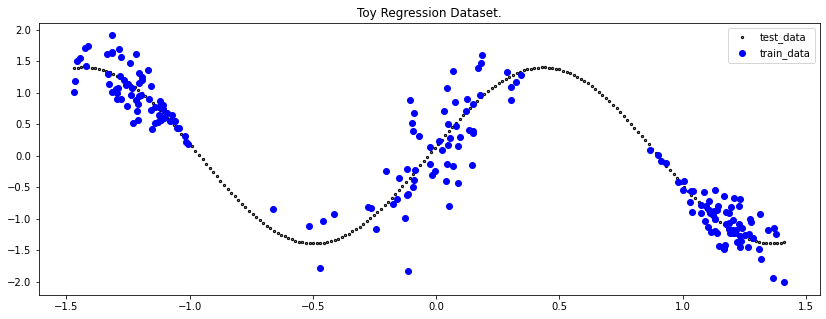

In [16]:
dm = ToyHeteroscedasticDatamodule(batch_size=32,)

X_train, Y_train, train_loader, X_test, Y_test, test_loader,  = (
    dm.X_train,
    dm.y_train,
    dm.train_dataloader(),
    dm.X_test,
    dm.y_test,
    dm.test_dataloader(),

)

fig = plot_toy_regression_data(X_train, Y_train, X_test, Y_test)

In [39]:
# train the pre-conditioning model
network = MLP(n_inputs=1, n_hidden=[50, 50, 50], n_outputs=1)

cond_mean_model = DeterministicRegression(
    model=network, optimizer=partial(torch.optim.Adam, lr=1e-2), loss_fn=nn.MSELoss()
)

trainer = Trainer(
    max_epochs=100,  # number of epochs we want to train
    devices=[0],
    accelerator="gpu",
    enable_checkpointing=False,
    enable_progress_bar=True,
    default_root_dir=tempfile.mkdtemp(),
)
trainer.fit(cond_mean_model, dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /var/folders/z6/vhr0xhx51s9bcs6y5nc2p7xr0000gn/T/tmpjuduuuo2/lightning_logs

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MLP              | 5.3 K 
1 | loss_fn       | MSELoss          | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
5.3 K     Trainable params
0         Non-trainable params
5.3 K     Total params
0.021     Total estimated model params size (MB)


/Users/williamkeely/miniconda3/envs/torch/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/williamkeely/miniconda3/envs/torch/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/williamkeely/miniconda3/envs/torch/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 499: 100%|██████████| 7/7 [00:00<00:00, 39.00it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 7/7 [00:00<00:00, 37.20it/s, v_num=0]


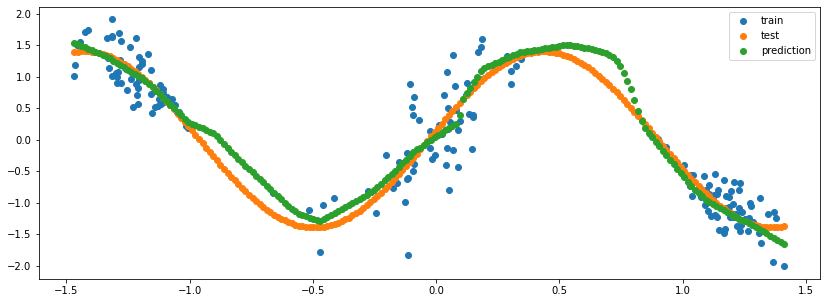

In [40]:
preds = cond_mean_model.predict_step(X_test)
fig, ax = plt.subplots(1)
ax.scatter(X_train, Y_train, label="train")
ax.scatter(X_test, Y_test, label="test")
ax.scatter(X_test, preds["pred"], label="prediction")
plt.legend()

In [49]:
# Conditional Diffusion
n_steps = 1000  # number of diffusion steps
cat_x = True  # condition on input x through concatenation
cat_y_pred = True  # condition on y_0_hat

x_dim = 1
y_dim = 1

n_hidden = [128, 128]

beta_schedule = "linear"
beta_start = 0.0001
beta_end = 0.02
guidance_model = ConditionalGuidedLinearModel(
    n_steps=n_steps,
    x_dim=x_dim,
    y_dim=y_dim,
    n_hidden=n_hidden,
    cat_x=cat_x,
    cat_y_pred=cat_y_pred,
)
card_model = CARDRegression(
    cond_mean_model=cond_mean_model.model,
    guidance_model=guidance_model,
    guidance_optim=partial(torch.optim.Adam, lr=1e-2),
    beta_schedule=beta_schedule,
    beta_start=beta_start,
    beta_end=beta_end,
    n_steps=n_steps,
)



logger = CSVLogger(my_temp_dir)
diff_trainer = Trainer(
    max_epochs=1000,  # number of epochs we want to train
    accelerator="gpu",
    devices=[0],
    logger=logger,
    log_every_n_steps=10,
    enable_checkpointing=False,
    enable_progress_bar=True,
    default_root_dir=my_temp_dir,
)
diff_trainer.fit(card_model, dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type                         | Params
-----------------------------------------------------------------
0 | cond_mean_model | MLP                          | 5.3 K 
1 | guidance_model  | ConditionalGuidedLinearModel | 273 K 
2 | train_metrics   | MetricCollection             | 0     
3 | val_metrics     | MetricCollection             | 0     
4 | test_metrics    | MetricCollection             | 0     
-----------------------------------------------------------------
278 K     Trainable params
0         Non-trainable params
278 K     Total params
1.114     Total estimated model params size (MB)


/Users/williamkeely/miniconda3/envs/torch/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/williamkeely/miniconda3/envs/torch/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/williamkeely/miniconda3/envs/torch/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 999: 100%|██████████| 7/7 [00:00<00:00, 59.48it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 7/7 [00:00<00:00, 59.21it/s, v_num=4]


In [50]:
card_model = card_model.to("cpu")
preds_1 = card_model.predict_step(X_test.cpu())
preds_2 = card_model.predict_step(X_test.cpu())
preds_3 = card_model.predict_step(X_test.cpu())
preds_4 = card_model.predict_step(X_test.cpu())
preds_5 = card_model.predict_step(X_test.cpu())

# average the preds to get the final preds and pred_uct
preds = {
    "pred": torch.stack([preds_1["pred"], preds_2["pred"], preds_3["pred"], preds_4["pred"], preds_5["pred"]]).mean(0),
    "pred_uct": torch.stack([preds_1["pred_uct"], preds_2["pred_uct"], preds_3["pred_uct"], preds_4["pred_uct"], preds_5["pred_uct"]]).mean(0),
    "aleatoric_uct": torch.stack([preds_1["aleatoric_uct"], preds_2["aleatoric_uct"], preds_3["aleatoric_uct"], preds_4["aleatoric_uct"], preds_5["aleatoric_uct"]]).mean(0),
}

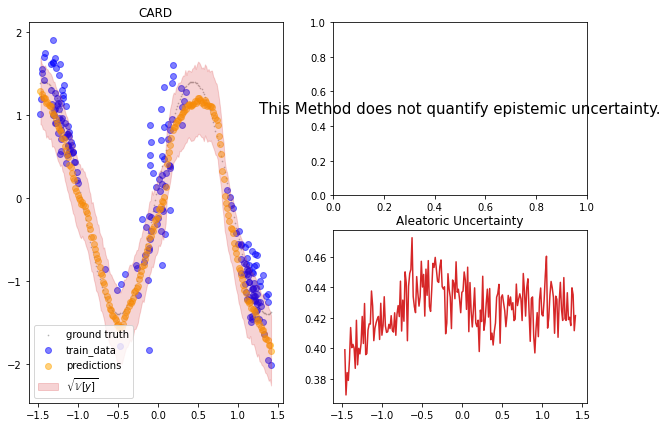

In [51]:
fig = plot_predictions_regression(
    X_train,
    Y_train,
    X_test,
    Y_test,
    preds["pred"],
    preds["pred_uct"],
    aleatoric=preds["aleatoric_uct"],
    title="CARD",
    show_bands=False,
)

<Figure size 1008x360 with 0 Axes>

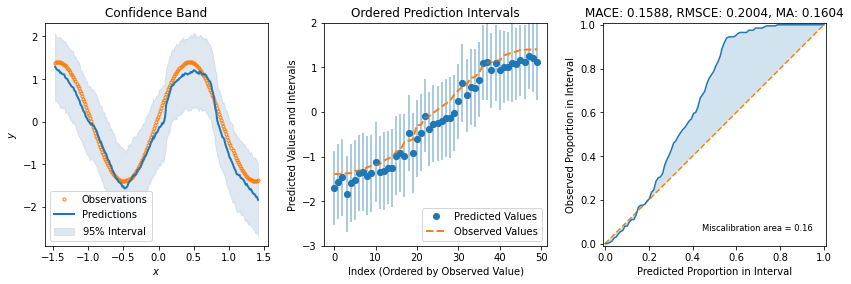

In [52]:

fig = plot_calibration_uq_toolbox(
    preds["pred"].cpu().numpy(),
    preds["pred_uct"].cpu().numpy(),
    Y_test.cpu().numpy(),
    X_test.cpu().numpy(),
)